In [45]:
import random
import torch
from d2l import torch as d2l

### 构造数据集

In [46]:

def synthetic_data(w, b, num_examples):
    """generate y = Xw + b +噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))#利用标准正太分布生成随机变量
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)#加入噪声
    return X, y.reshape((-1, 1))
    #.reshape((-1,1)) -1表示自动计算，1表示固定列向量为1
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

### 展示数据集

In [47]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.7460,  0.8435]) 
label: tensor([-0.1698])


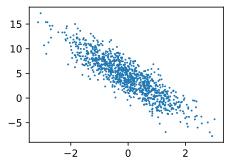

In [48]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),
labels.detach().numpy(), 1)

### 定义一个data_iter函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [49]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #为了训练效果更好，一般要求读取的数据顺序随机排列
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]# yield 就是循环操作，直到取完examples

batch_size = 20
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 7.1098e-01, -2.8686e+00],
        [ 2.8785e-01, -6.1773e-02],
        [ 1.0341e+00,  1.5045e-01],
        [ 6.9686e-01,  2.0452e+00],
        [ 1.8315e-01, -1.2118e+00],
        [-5.8391e-01, -6.7523e-01],
        [-1.2415e+00,  5.1946e-01],
        [-1.5571e+00,  2.0719e-03],
        [-6.8544e-01, -1.6560e+00],
        [-5.7960e-01, -8.7276e-01],
        [ 4.8970e-01, -1.2745e+00],
        [-6.2420e-01,  3.5285e-01],
        [ 1.4009e+00,  7.0155e-01],
        [ 9.0279e-01,  5.8574e-01],
        [ 2.6429e-01,  3.1737e-01],
        [-1.1545e-02, -1.0974e+00],
        [ 9.7131e-02, -1.1041e+00],
        [-5.4772e-01,  1.5216e+00],
        [ 2.1096e-01,  1.0909e+00],
        [-4.8751e-01,  1.5819e+00]]) 
 tensor([[15.3799],
        [ 4.9773],
        [ 5.7540],
        [-1.3625],
        [ 8.6906],
        [ 5.3250],
        [-0.0624],
        [ 1.0713],
        [ 8.4486],
        [ 6.0065],
        [ 9.5093],
        [ 1.7657],
        [ 4.6109],
        [ 4.0078],
        [ 3

### 初始化模型参数

In [50]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)#偏差初始值直接给0，等待后续更新

### 定义模型

In [51]:
def linreg(X, w, b):
    """"线性回归模型"""
    """三引号作用
    是注释
    换行"""
    return torch.matmul(X, w) + b
    


### 定义损失函数

In [52]:
def squared_loss(y_hat, y):
    '''均方损失'''
    return (y_hat - y.reshape(y_hat.shape))**2 / 2


### 定义优化算法，应该就是梯度下降法

In [53]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降法"""
    #计算导数是一件计算量很大的事，因此在不必要的时候，不计算梯度
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()##这里继续看下
            # 在这里传进来都是batch_size，所以都是batch_size的操作，需要求平均值
    #看看在后面怎么使用的，包括为啥要除以batch_size

### 训练过程

In [54]:
lr = 0.05
num_epoches = 4
net = linreg
loss = squared_loss

for epoch in range(num_epoches):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # l是向量而非标量，squareed-loss返回的是长num_examples宽为1的向量
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        #采用的是真实值计算的epoch，实际上除了train,还有test。
        #一直不明白的还是torch里面的tensor，感觉基本好像是同等操作
        #这里应该还是.mean()和.sum()一样，对向量所有的加在一起求平均

epoch 1, loss 0.074793
epoch 2, loss 0.000387
epoch 3, loss 0.000050
epoch 4, loss 0.000049


### 评估函数

In [55]:
print(f'w的估计误差是: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')


w的估计误差是: tensor([ 0.0003, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
